# Put all classes in here so I can try running games

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class User():
    """This class creates users that are to be shown ads"""
    
    def __init__(self):
        self.__probability = np.random.uniform(0, 1)
    
    def show_ad(self):
        """Returns a boolean: True if the user clicks on the add, False otherwise. Remember that the user's 
        likelihood of clicking is not influenced at all by who the specific bidder is that shows the ad. All that
        matters is the user's secret probability of clicking"""
        
        ad_id = np.random.uniform(0, 1)
        if ad_id <= self.__probability:
            return True
        else:
            return False
    
    # this method is just for development purposes, I might remove
    def get_prob(self):
        return round(self.__probability, 2)

In [3]:
class Bidder():
    """This class creates bidders equipped with knowledge of the number of users in the auction and the number 
    of auction rounds to be played"""
    
    def __init__(self, num_users, num_rounds):
        # each user has a list associated with their user_id: first entry is num_clicks, second is num_ads_shown,
        # third is the quotient of the two representing the best estimate of their clicking likelihood
        self.prob_estimates = {i:[0,0,0] for i in range(num_users)}
        self.prices_by_user = {i:[] for i in range(num_users)}
        self.current_user = 0
    
    def bid(self, user_id):
        """Returns a non-negative amount of money. If you don't wish to bid anything on a given user, this should 
        return 0.
        This is where at least some of the main logic will need to go. Maybe not the core explore/exploit strategy, 
        but at least the consequence of that strategy."""
        # going to start by creating a stupid bidder that has no concept of explore/exploit strategy
        # this bidder will not consider the relative probabilities of different users choosing to click
        self.current_user = user_id
        
        return np.random.uniform()

    
    def notify(self, auction_winner, price, clicked=None):
        """Used to send info about what happened in a round back to the bidder. auction_winner will be a boolean:
        True if the bidder won a given round, False otherwise. price will be the amount of the second bid, only the
        winner pays this. clicked will only take on a value if auction_winner is True (if the bidder won that given
        round) in which case it will take on a boolean value: True if the user clicked on the ad and False 
        otherwise"""
        if auction_winner:        # If the bidder won the auction
            if clicked:           # Additionally, if the user clicked
                # update the prob_estimates dictionary for the current user
                self.prob_estimates[self.current_user][0] += 1
                self.prob_estimates[self.current_user][1] += 1
                self.prob_estimates[self.current_user][2] = self.prob_estimates[self.current_user][0] / self.prob_estimates[self.current_user][1]
            else:  # if the user didn't click
                # update the prob_estimates dictionary for the current user
                self.prob_estimates[self.current_user][1] += 1
                self.prob_estimates[self.current_user][2] = self.prob_estimates[self.current_user][0] / self.prob_estimates[self.current_user][1]
        # record the winning price and attach it to the appropriate user for each round, what do OTHER people think that user is worth?
        self.prices_by_user[self.current_user].append(price)

In [4]:
class Bidder0(Bidder):
    def bid(self, user_id):
        return 0

In [5]:
class Bidder1(Bidder):
    def __init__(self, num_users, num_rounds, alpha=0.35, aggressiveness=0.6, under_cut=0):
        super().__init__(num_users, num_rounds)
        self.alpha = alpha
        self.num_users = num_users
        self.num_rounds = num_rounds
        self.under_cut = under_cut
        self.current_round = 0
        self.aggressiveness = aggressiveness
        
    def bid(self, user_id):
        """Explore for the first alpha of the game, then exploit"""
        self.current_user = user_id
        
        if self.current_round / self.num_rounds < self.alpha:
            self.current_round += 1
            # return an aggressive bid
            return self.aggressiveness
        else:
            self.current_round += 1
            # return a bid that is based on my estimate of the given user's clicking likelihood 
            bid = self.prob_estimates[user_id][2] - self.under_cut
            return bid
        

In [6]:
class Auction():
    """This class creates Auction objects. So a given auction object will have info on the number of bidders
    and the number of users in the game. You can call the .execute_rounds() method as many times as you want rounds  
    in your auction. 
    Attributes are:
    bidders
    users
    balances
    winning_prices
    wins_by_bidder
    bids_by_user
    winning_price_by_user
    num_rounds
    balances_by_round"""
    
    def __init__(self, users, bidders):
        self.bidders = bidders
        self.users = users
        self.balances = {bidder:0 for bidder in self.bidders} # finances will be completely handled in Auction class
        self.winning_prices = []
        self.wins_successes_by_bidder = {bidder:[0,0] for bidder in self.bidders} # keep track of how many wins each bidder has
        self.bids_by_user = {i:[0,0] for i in range(len(users))} # keep track of the average of EVERY bid by user
        self.winning_price_by_user = {i:[0,0] for i in range(len(users))} # keep track of the average of WINNING PRICE by user
        self.num_rounds = 0
        self.balances_by_round = {bidder:[0] for bidder in self.bidders}
        self.secret_probs = [user.get_prob() for user in users]
        self.rounds = {}
    
    def execute_round(self):
        """This should execute all the steps within a single round of the game"""
        
        # choose a user at random
        user = np.random.randint(0, len(self.users)) 
        
        bids = {} # store the bids in a dictionary --> bidder is the key, their bid is the value
        # call bid for each bidder using the id of the chosen user
        for bidder in self.bidders:
            bid = bidder.bid(user)
            bids[bidder] = bid
        
        # loop through the bids dictionary to figure out the winning_bidder and the second_highest_bid
        max_bid = 0            # only for the purpose of determining winning_bidder
        second_highest_bid = 0 # starts at zero
        for bidder,bid in bids.items():
            if bid > max_bid:
                second_highest_bid = max_bid
                max_bid = bid
                winning_bidder = bidder     # set/update winning bidder
            elif bid > second_highest_bid:
                second_highest_bid = bid    # update second_highest price
            
        # show the ad to the user
        ad_outcome = self.users[user].show_ad()
        
        # loop through the bidders to notify each of them of the outcome of the auction round
        # also adjust their balances accordingly
        for bidder in self.bidders:
            # the winner also gets to find out the result of showing the add to the user
            if bidder == winning_bidder:
                bidder.notify(True, second_highest_bid, ad_outcome) 
                self.balances[bidder] -= second_highest_bid
                if ad_outcome:
                    self.balances[bidder] += 1
                    self.wins_successes_by_bidder[bidder][1] += 1 # just for diagnostics, not crucial
                self.wins_successes_by_bidder[bidder][0] += 1 # just for diagnostics, not crucial
            else:
                bidder.notify(False, second_highest_bid)
        
        # following four blocks are just for diagnostics, not crucial
        bids_mean = np.mean([bid for bid in bids.values()]) # take the average of the bids for this round
        # and update the instance attribute bids_by_user to update the average bid for them
        self.bids_by_user[user][0] = (self.bids_by_user[user][0] + bids_mean)/(self.bids_by_user[user][1] + 1)
        self.bids_by_user[user][1] += 1 # increment the number of rounds that they've been selected by 1
        
        # update the average of the winning prices for each user
        self.winning_price_by_user[user][0] = (self.winning_price_by_user[user][0] + second_highest_bid)/(self.winning_price_by_user[user][1] + 1)
        self.winning_price_by_user[user][1] += 1 # increment the number of rounds they've been selected by 1
        
        # update balances by round to see the history of the bidders balances over the course of the game
        for bidder in self.bidders: 
            self.balances_by_round[bidder].append(self.balances[bidder])
        
        # update num_rounds
        self.num_rounds += 1
        
        self.rounds[self.num_rounds] = [user, self.secret_probs[user], ad_outcome]
        
        self.winning_prices.append(second_highest_bid)
                
                
    # optional
    def plot_history(self, info_type="balance_history"):
        """Create a visual representation of how the auction has proceeded. 
        info_type parameter determines what type of graph you are shown. Options are:
        balance_history
        wins_by_bidder
        winning_prices
        bids_by_user
        winning_price_by_user
        summary_by_round
        """
        
        if info_type == "balance_history":
            x = np.arange(self.num_rounds + 1)
            # create several lists, each representing the history of each bidder's balance over the course of the game
            y = [[balance for balance in self.balances_by_round[bidder]] for bidder in self.bidders]
            for bidder in y:
                plt.plot(x,bidder)
            plt.legend(["bidder" + str(i) for i in range(len(y))])
            plt.xlabel("round")
            plt.ylabel("balance")
            plt.title("history of balances by user over the rounds")
            plt.show()
        
        elif info_type == "wins_by_bidder":
            x = ["bidder" + str(i) for i in range(len(self.bidders))]
            num_wins = [self.wins_successes_by_bidder[bidder][0] for bidder in self.bidders]
            num_successes = [self.wins_successes_by_bidder[bidder][1] for bidder in self.bidders]
            
            w = 0.4
            bar1 = np.arange(len(x))
            bar2 = [i+w for i in bar1]
            
            plt.bar(bar1, num_wins, w, label="number of wins")
            plt.bar(bar2, num_successes, w, label="number of successes")
            
            plt.xticks(bar1+w/2, x)
            plt.xlabel("bidder")
            plt.ylabel("wins and successes")
            plt.legend()
            plt.title("Number of wins and successes by bidder")
            plt.show()
            
        elif info_type == "winning_prices":
            x = np.arange(1, self.num_rounds+1)
            y = [winning_price for winning_price in self.winning_prices]
            plt.scatter(x,y)
            plt.xlabel("round number")
            plt.ylabel("price")
            plt.title("winning prices by rounds")
            plt.show()
            
        elif info_type == "bids_by_user":
            x = np.arange(len(self.users))
            y = [pair[0] for pair in self.bids_by_user.values()]
            z = [prob for prob in self.secret_probs]
            
            w = 0.4
            bar1 = np.arange(len(x))
            bar2 = [i+w for i in bar1]
            
            plt.bar(bar1, y, w, label="average of bids")
            plt.bar(bar2, z, w, label="secret probabilities")
            
            plt.xticks(bar1+w/2, x)
            
            plt.xlabel("user_id")
            plt.ylabel("bid amount and secret probability")
            plt.title("comparison of bidders attempts per user vs users' actual clicking likelihoods")
            plt.legend()
            plt.show()
            
        elif info_type == "winning_price_by_user":
            x = np.arange(len(self.users))
            y = [pair[0] for pair in self.winning_price_by_user.values()]
            plt.bar(x,y)
            plt.xlabel("user_id")
            plt.ylabel("bid amount")
            plt.title("average of the winning bids in each round by user")
            plt.show()
            
        elif info_type == "summary_by_round":
            # I want to know which user was selected
            # I want to know their clicking likelihood
            # I want to know whether they clicked
            # I want to know which bidder won **
            # I want to know the winning price
            return self.rounds
            
            
            
            

In [7]:
def summarize_auction(auction):
    """Call all of the summary plot"""
    
    auction.plot_history(info_type="summary_by_round")
    auction.plot_history(info_type="wins_by_bidder")
    auction.plot_history()
    auction.plot_history(info_type="winning_prices")
    auction.plot_history(info_type="bids_by_user")
    auction.plot_history(info_type="winning_price_by_user")

## Function to analyze auctions

In [8]:
def auction_overview(auction):
    """Given a completed auction (an auction object for which .execute() has been repeatedly called),
    summarize the attributes of the bidders involved and indicate the final balance of each bidder"""
    
    dicty = {"bidder_id": [],
             "bidder_class": [],
             "alpha": [],
             "aggressiveness": [],
             "under_cut": [],
             "num_users": [],
             "final_balance": []}

    for bidder in auction.bidders:
        dicty["bidder_id"].append(bidder)
        dicty["bidder_class"].append(bidder.__class__)
        if bidder.__class__ == Bidder1:
            dicty["alpha"].append(bidder.alpha)
            dicty["aggressiveness"].append(bidder.aggressiveness)
            dicty["under_cut"].append(bidder.under_cut)
        else:
            dicty["alpha"].append("NA")
            dicty["aggressiveness"].append("NA")
            dicty["under_cut"].append("NA")
        dicty["num_users"].append(len(auction.users))
        dicty["final_balance"].append(auction.balances[bidder])

    summary_df = pd.DataFrame(dicty)
    
    return summary_df

## Experiments

### Experiment 1

* 1 smart bidder 
    - alpha = 0.1
    - aggressiveness = 0.85
    - undercut = 0.1
* 1 zero bidder
* 5 random bidders

In [9]:
auction1 = Auction([User() for i in range(7)], [Bidder0(7, 1000)] + [Bidder1(7, 1000, 0.1, 0.85, 0.1)] + 
                   [Bidder(7, 1000) for i in range(5)])

In [10]:
auction1.secret_probs

[0.87, 0.21, 0.75, 0.85, 0.93, 0.62, 0.73]

In [11]:
for i in range(1000):
    auction1.execute_round()

In [12]:
# auction1.plot_history(info_type="summary_by_round")

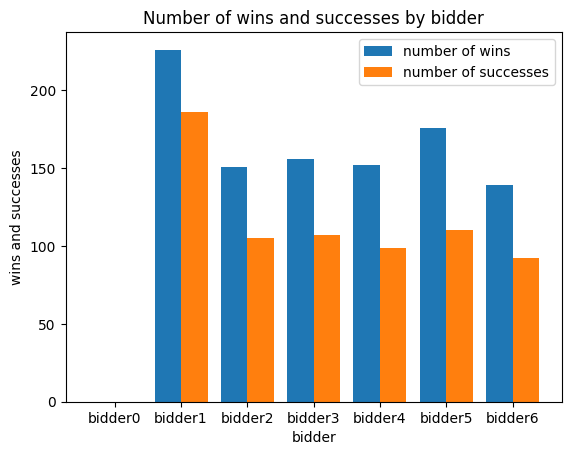

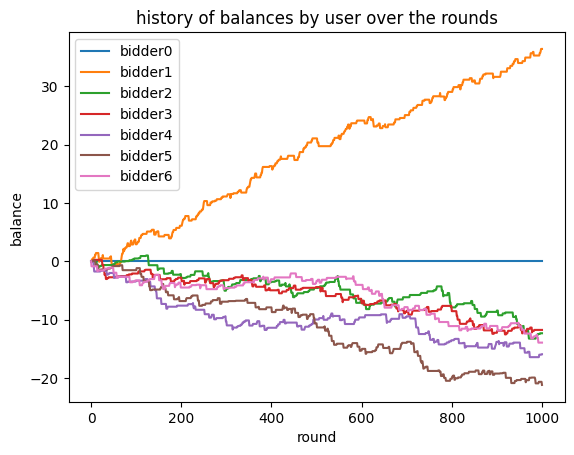

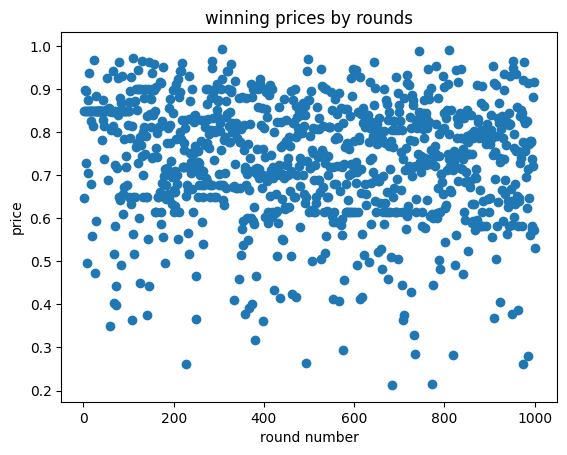

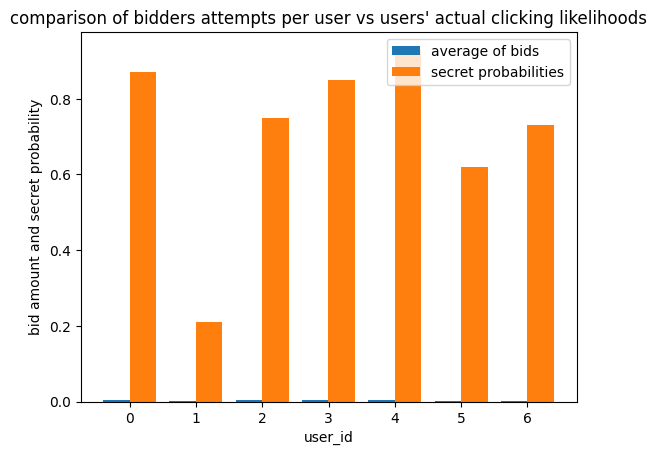

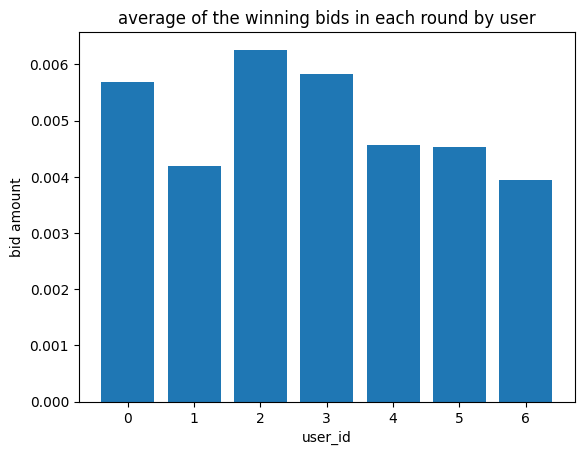

In [13]:
summarize_auction(auction1)

In [14]:
auction_overview(auction1)

,bidder_id,bidder_class,alpha,aggressiveness,under_cut,num_users,final_balance
0,<__main__.Bidder0 object at 0x11f74a990>,<class '__main__.Bidder0'>,NA,NA,NA,7,0.000000
1,<__main__.Bidder1 object at 0x11f74b750>,<class '__main__.Bidder1'>,0.1,0.85,0.1,7,36.398315
2,<__main__.Bidder object at 0x11f74bc10>,<class '__main__.Bidder'>,NA,NA,NA,7,-12.328407
3,<__main__.Bidder object at 0x11f16e7d0>,<class '__main__.Bidder'>,NA,NA,NA,7,-11.753234
4,<__main__.Bidder object at 0x11f748250>,<class '__main__.Bidder'>,NA,NA,NA,7,-15.920865
5,<__main__.Bidder object at 0x11f748850>,<class '__main__.Bidder'>,NA,NA,NA,7,-21.180855
6,<__main__.Bidder object at 0x11f748c10>,<class '__main__.Bidder'>,NA,NA,NA,7,-13.931148


### Experiment 2

* 1 smart bidder
* 1 zero bidder

In [15]:
smarter_bidders = [Bidder0(5, 200)] + [Bidder1(5, 200, 0.5)] 

In [16]:
auction2 = Auction([User() for i in range(5)], smarter_bidders)

In [17]:
auction2.secret_probs

[0.11, 0.25, 0.54, 0.34, 0.41]

In [18]:
for i in range(200):
    auction2.execute_round()

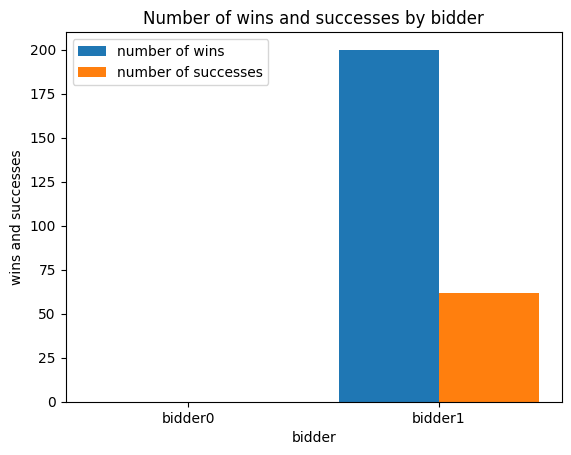

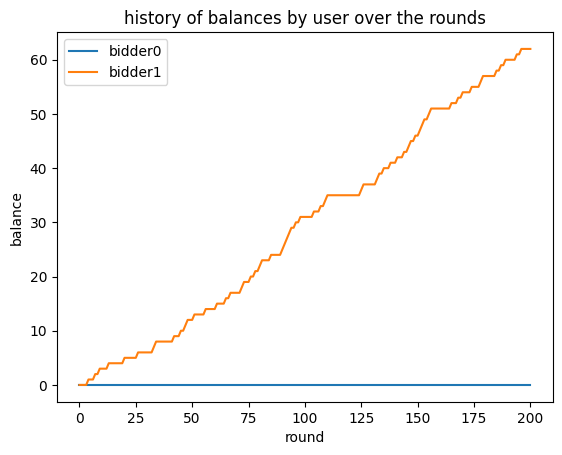

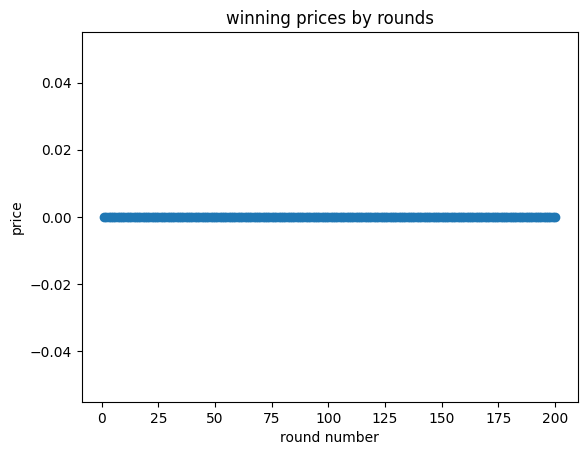

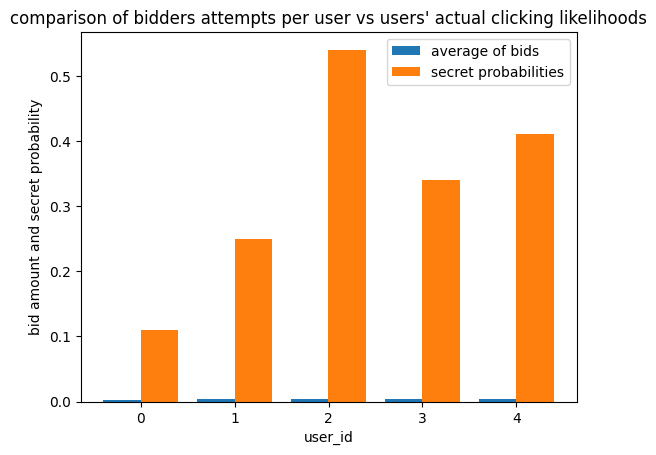

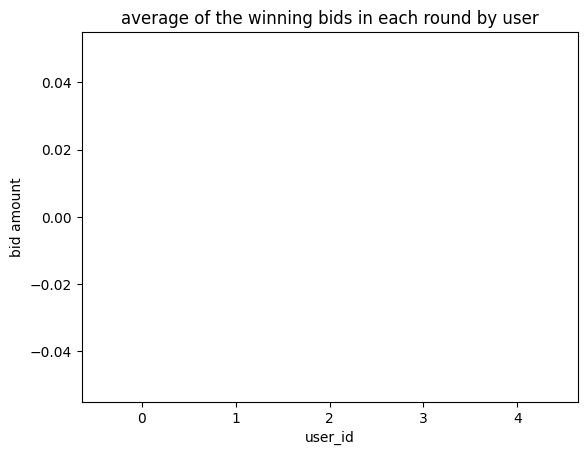

In [19]:
summarize_auction(auction2)

In [20]:
auction_overview(auction2)

,bidder_id,bidder_class,alpha,aggressiveness,under_cut,num_users,final_balance
0,<__main__.Bidder0 object at 0x1044b8590>,<class '__main__.Bidder0'>,NA,NA,NA,5,0
1,<__main__.Bidder1 object at 0x11f962690>,<class '__main__.Bidder1'>,0.5,0.6,0,5,62


### Experiment 3

In [21]:
users = [User() for i in range(5)]
bidders = [Bidder0(num_users=5, num_rounds=1000), 
           Bidder1(num_users=5, num_rounds=1000, alpha=0.35, aggressiveness=0.6, under_cut=0),
           Bidder1(num_users=5, num_rounds=1000, alpha=0.1, aggressiveness=0.9, under_cut=0.1),
           Bidder1(num_users=5, num_rounds=1000, alpha=0.6, aggressiveness=0.75, under_cut=0.2),
           Bidder(num_users=5, num_rounds=1000)]

auction3 = Auction(users, bidders)

In [22]:
for i in range(1000):
    auction3.execute_round()

In [23]:
auction_overview(auction3)

,bidder_id,bidder_class,alpha,aggressiveness,under_cut,num_users,final_balance
0,<__main__.Bidder0 object at 0x11f9a8950>,<class '__main__.Bidder0'>,NA,NA,NA,5,0.000000
1,<__main__.Bidder1 object at 0x11f9a89d0>,<class '__main__.Bidder1'>,0.35,0.6,0,5,0.000000
2,<__main__.Bidder1 object at 0x11f9a8890>,<class '__main__.Bidder1'>,0.1,0.9,0.1,5,156.425746
3,<__main__.Bidder1 object at 0x11f9a8910>,<class '__main__.Bidder1'>,0.6,0.75,0.2,5,-20.573011
4,<__main__.Bidder object at 0x11f9a88d0>,<class '__main__.Bidder'>,NA,NA,NA,5,0.364702


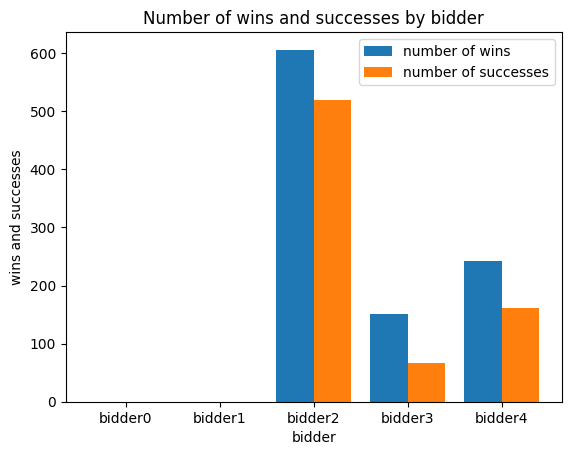

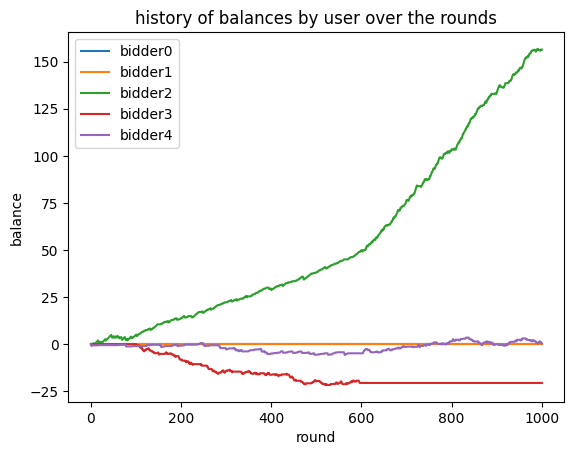

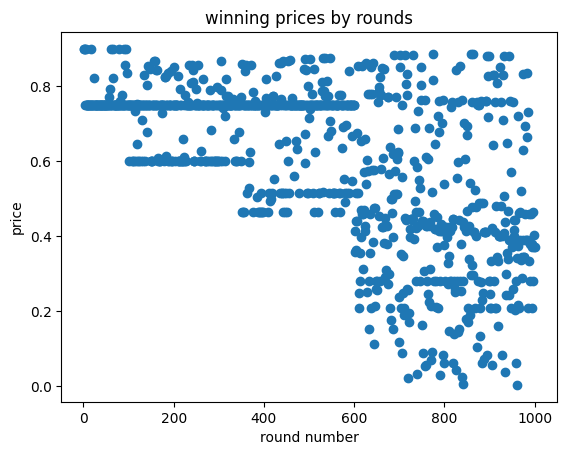

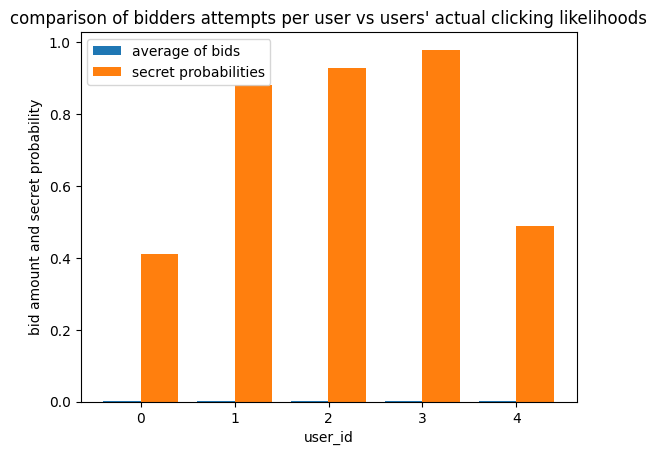

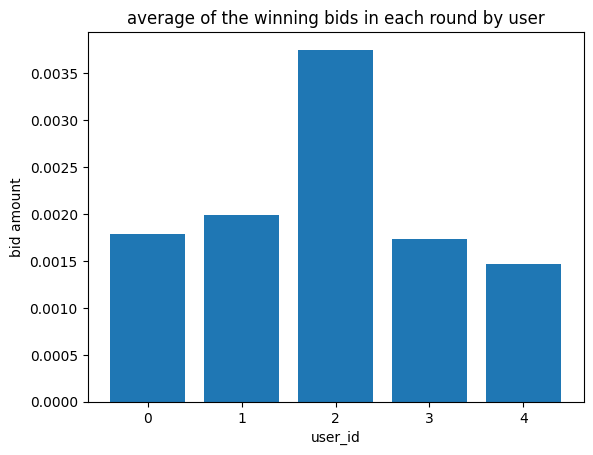

In [24]:
summarize_auction(auction3)